# <center> **How to use MOABB and how to validate any algorithm** </center>

The Mother of All BCI Benchmarks (MOABB) is a python library that comprehends all free popular Brain-Computer Interface (BCI) EEG datasets to validate any algorithm for BCIs. Brain-Computer Interface are devices that allows to control by using brain signals, for this, is possible to model different algorithms based on brain data to classify theses signals. After modeling, these algorithms must be validated, in order to know if they are able to accurately predict the brain signal. 

At first, sounds easy to train and validate theses models to classify brain signals, but due to non-stacionary and low Signal-To-Noise (SNR) features of the brain signals recorded by Electroencefalogran (EEG), is pretty difficult to model algorithms that can generalize for different multiple different trials, subjects and sessions. When fresh research about BCI shows the results of an new algorithm that can performn well compared to others, it lacks of generalization between subjects. And when some reasechers tries to use multiple datasets to validate its model, its is very dificult, due to necessity of different *pipelines* to process the data.

To solve this issue [1] developed an python library that has many free EEG datasets that be used to validate an new classification model of brain signals. Is this tutorial will shown how to use this library to validate your own algorithm to classify brain signals.

## **1. Installing MOABB**

To install this library is necessary to have Python version 3.8+ already installed on your machine `python==3.8+`, and Pip package installer. With this prerequisite satified, execute following command on your terminal: `pip install moabb`. It is also possible to execute command on the notebook:

In [3]:
# %pip install moabb

Installing MOABB will automatically install necessary libraries to manipulate data, such as `MNE` and `numpy`. If you and to Guarrantee that all libraries were installed you can also execute the previous command for `numpy` and `mne`, just need to basically: `pip install <package>`, were `<package>` if the name of the library you want to install.

In [4]:
#%pip install mne numpy

## **2. Importing Libraries**

After installing necessary, we must import them to be usable, using `import`. In our case will be using `import moabb`.

In [33]:
import copy
import numpy
import moabb

from mne.decoding import CSP
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.pipeline import make_pipeline


## **3. Datasets available**

The datasets available in this library are separeted by EEG paradigms, such as **Imagery**, **P300**, **State Steady Visual Evoked Potentials (SSVEP)**, **CVEP** and **Resting State**. It is possible to visualize all dataset available by printing `moabb.datasets.utils.dataset_list`.

In [23]:
# List of all dataset
all_datasets = copy.copy(moabb.datasets.utils.dataset_list) # Getting a copy for data safety

In [7]:
print(f"Number of datasets: {len(all_datasets)}")
print(all_datasets)

Number of datasets: 77
[<class 'moabb.datasets.alex_mi.AlexMI'>, <class 'moabb.datasets.braininvaders.BI2012'>, <class 'moabb.datasets.braininvaders.BI2013a'>, <class 'moabb.datasets.braininvaders.BI2014a'>, <class 'moabb.datasets.braininvaders.BI2014b'>, <class 'moabb.datasets.braininvaders.BI2015a'>, <class 'moabb.datasets.braininvaders.BI2015b'>, <class 'moabb.datasets.bnci.BNCI2014001'>, <class 'moabb.datasets.bnci.BNCI2014002'>, <class 'moabb.datasets.bnci.BNCI2014004'>, <class 'moabb.datasets.bnci.BNCI2014008'>, <class 'moabb.datasets.bnci.BNCI2014009'>, <class 'moabb.datasets.bnci.BNCI2014_001'>, <class 'moabb.datasets.bnci.BNCI2014_002'>, <class 'moabb.datasets.bnci.BNCI2014_004'>, <class 'moabb.datasets.bnci.BNCI2014_008'>, <class 'moabb.datasets.bnci.BNCI2014_009'>, <class 'moabb.datasets.bnci.BNCI2015001'>, <class 'moabb.datasets.bnci.BNCI2015003'>, <class 'moabb.datasets.bnci.BNCI2015004'>, <class 'moabb.datasets.bnci.BNCI2015_001'>, <class 'moabb.datasets.bnci.BNCI2015_003

It is also possible to select these datasets by its paradigm, it is possible to do this by using `moabb.datasets.utils.dataset_search()` function, where we can pass some parameters to select the perfect dataset we want, one of these parameters is `paradigm`, which can be `'imagery'`, `'p300'`, `'ssvep'` and `'cvep'`.

In [8]:
# Selecting SSVEP paradigm
ssvep_datasets = copy.deepcopy(moabb.datasets.utils.dataset_search(paradigm='ssvep'))

In [9]:
print(f"Number of SSVEP datasets: {len(ssvep_datasets)}")
print(ssvep_datasets)

Number of SSVEP datasets: 7
[<moabb.datasets.ssvep_exo.Kalunga2016 object at 0x000001C9417E5810>, <moabb.datasets.Lee2019.Lee2019_SSVEP object at 0x000001C9417E58D0>, <moabb.datasets.ssvep_mamem.MAMEM1 object at 0x000001C9417E5690>, <moabb.datasets.ssvep_mamem.MAMEM2 object at 0x000001C9417E5C00>, <moabb.datasets.ssvep_mamem.MAMEM3 object at 0x000001C9417E5780>, <moabb.datasets.ssvep_nakanishi.Nakanishi2015 object at 0x000001C9417E5630>, <moabb.datasets.ssvep_wang.Wang2016 object at 0x000001C9417E56C0>]


In the function `moabb.datasets.utils.dataset_search()` there are other parameters to filter, such as: 
* `multi_session` - Returns just the datasets that that has more than one session per subject.
* `events` - Type of event to select.
* `has_all_events` - Select dataset with all types of events.
* `interval` - (Motor Imagery Only) minimal time length of the event.
* `min_subjects` - Minum number of subjects in an dataset.
* `channels` - List of channels.


In [10]:
moabb.datasets.utils.dataset_search(paradigm='imagery',
                                    multi_session=True,
                                    min_subjects=10)

It also possible to create fake dataset using Python library `fake` [2]. When used the functions used above, it shows class `moabb.datasets.fake.FakeDataset()`, which is a class implemented for test purpose.

In [11]:
fake_data = moabb.datasets.fake.FakeDataset(event_list=['fake1', 'fake2'],
                                            n_sessions=2,
                                            n_runs=2,
                                            paradigm='imagery',
                                            channels=('C3', 'Cz', 'C4'))

In [12]:
print(len(fake_data.get_data()))

10


## **4. Main Concepts**

Before diving into how to use these datasets to create an pipeline, it is important to know the four main concepts of the MOABB: (1) Datasets, (2) Paradigms, (3) Evaluation, and (4) Pipeline.

### **4.1 Datasets**

Since we already know how to seach and select desired datasets, we'll start selecting dataset for `imagery` paradigm.

In [22]:
# Selecting all datasets with motor imagery
imagery_datasets = copy.copy(moabb.datasets.utils.dataset_search(paradigm='imagery'))

It is possible to get the data by using `.get_data()` function. Before using this function, which will download each dataset, is important to set the path directory, by using `moabb.utils.set_downalod_dir(path)`.

In [ ]:
# Setting download path. Sometimes this function does not work
moabb.utils.set_download_dir(path='./datasets/')

In [ ]:
# Downloading each dataset
#[dataset.get_data() for dataset in imagery_datasets]

### **4.2 Paradigms**

As we explained before, there are four paradigms, which are: (1) Motor Imagery, (2) SSVEP, (3) P300, (4) CVEP, and (5) Resting State. Each of theses paradigms defines how raw MNE data will be processed and feed to the decoing algorithm.

For Motor imagery paradigm:
1. `MotorImagery()` - N Classes, N is the number of classes desired.
2. `LeftRightImagery()`
3. `FilterBankLeftRightImagery()`
4. `FilterBankMotorImagery()`

For P300 paradigm:
1. `SinglePass()`
2. `P300()`

For SSVEP paradigm:
1. `SSVEP()`
2. `FilterBankSSVEP`

For c-VEP Paradigms:
1. `CVEP()`
2. `FilterBankCVEP()`

For Resting State Paradigms:
1. `RestingStateToP300Adapter`

In [16]:
# Using LeftRight for MotorImagery
paradigm = moabb.paradigms.LeftRightImagery()

In [24]:
print(paradigm.datasets)

[<moabb.datasets.bnci.BNCI2014_001 object at 0x000001C94CC181C0>, <moabb.datasets.bnci.BNCI2014_004 object at 0x000001C94CC18520>, <moabb.datasets.gigadb.Cho2017 object at 0x000001C94CC18580>, <moabb.datasets.mpi_mi.GrosseWentrup2009 object at 0x000001C94CBABCA0>, <moabb.datasets.Lee2019.Lee2019_MI object at 0x000001C94CC19060>, <moabb.datasets.liu2024.Liu2024 object at 0x000001C94CC18550>, <moabb.datasets.physionet_mi.PhysionetMI object at 0x000001C94CC19030>, <moabb.datasets.schirrmeister2017.Schirrmeister2017 object at 0x000001C94CC191B0>, <moabb.datasets.bbci_eeg_fnirs.Shin2017A object at 0x000001C94C4159C0>, <moabb.datasets.stieger2021.Stieger2021 object at 0x000001C94CC18640>, <moabb.datasets.Weibo2014.Weibo2014 object at 0x000001C94CC184C0>, <moabb.datasets.Zhou2016.Zhou2016 object at 0x000001C94CC18280>]


In [30]:
X, labels, meta = paradigm.get_data(dataset=imagery_datasets[1], subjects=[1])

c:\Users\erika\Documents\Code\moabb_study\.venv\lib\site-packages\urllib3\connectionpool.py:1064: InsecureRequestWarning: Unverified HTTPS request is being made to host 'lampx.tugraz.at'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
100%|#####################################| 42.8M/42.8M [00:00<00:00, 21.4GB/s]
SHA256 hash of downloaded file: 054f02e70cf9c4ada1517e9b9864f45407939c1062c6793516585c6f511d0325
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.
c:\Users\erika\Documents\Code\moabb_study\.venv\lib\site-packages\urllib3\connectionpool.py:1064: InsecureRequestWarning: Unverified HTTPS request is being made to host 'lampx.tugraz.at'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
100%|

### **4.3 Pipeline**

A pipeline in ML/DATA engineering refers to the end-to-end sequence of steps that data undergoes—from raw input to model predictions (or insights). Is this case we will be using for model training. We will me using scikit function `make_pipeline` for this purpouse.

In [36]:
pipeline = make_pipeline(CSP(n_components=8), LDA())

### **4.4 Evaluation**

In [39]:
evaluation = moabb.evaluations.WithinSessionEvaluation(
    paradigm=paradigm,
    datasets=[imagery_datasets[0]],
    overwrite=True,
    hdf5_path=None,
)

In [40]:
results = evaluation.process({"csp+lda": pipeline})

BNCI2014-001-WithinSession:   0%|          | 0/9 [00:00<?, ?it/s]c:\Users\erika\Documents\Code\moabb_study\.venv\lib\site-packages\moabb\datasets\preprocessing.py:278: UserWarning: warnEpochs <Epochs | 24 events (all good), 2 – 6 s (baseline off), ~4.1 MiB, data loaded,
 'left_hand': 12
 'right_hand': 12>
  warn(f"warnEpochs {epochs}")
c:\Users\erika\Documents\Code\moabb_study\.venv\lib\site-packages\moabb\datasets\preprocessing.py:278: UserWarning: warnEpochs <Epochs | 24 events (all good), 2 – 6 s (baseline off), ~4.1 MiB, data loaded,
 'left_hand': 12
 'right_hand': 12>
  warn(f"warnEpochs {epochs}")
c:\Users\erika\Documents\Code\moabb_study\.venv\lib\site-packages\moabb\datasets\preprocessing.py:278: UserWarning: warnEpochs <Epochs | 24 events (all good), 2 – 6 s (baseline off), ~4.1 MiB, data loaded,
 'left_hand': 12
 'right_hand': 12>
  warn(f"warnEpochs {epochs}")
c:\Users\erika\Documents\Code\moabb_study\.venv\lib\site-packages\moabb\datasets\preprocessing.py:278: UserWarning: 

No hdf5_path provided, models will not be saved.
Computing rank from data with rank=None
    Using tolerance 33 (2.2e-16 eps * 22 dim * 6.7e+15  max singular value)
    Estimated rank (data): 22
    data: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 33 (2.2e-16 eps * 22 dim * 6.7e+15  max singular value)
    Estimated rank (data): 22
    data: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 32 (2.2e-16 eps * 22 dim * 6.6e+15  max singular value)
    Estimated rank (data): 22
    data: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estim

BNCI2014-001-WithinSession:  11%|█         | 1/9 [00:07<00:56,  7.11s/it]Downloading data from 'http://bnci-horizon-2020.eu/database/data-sets/001-2014/A02T.mat' to file 'C:\Users\erika\Documents\Code\moabb_study\notebooks\datasets\MNE-bnci-data\database\data-sets\001-2014\A02T.mat'.
c:\Users\erika\Documents\Code\moabb_study\.venv\lib\site-packages\urllib3\connectionpool.py:1064: InsecureRequestWarning: Unverified HTTPS request is being made to host 'lampx.tugraz.at'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


































































100%|#############################################| 43.1M/43.1M [00:00<?, ?B/s]
SHA256 hash of downloaded file: 5ddd5cb520b1692c3ba1363f48d98f58f0e46f3699ee50d749947950fc39db27
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the

No hdf5_path provided, models will not be saved.
Computing rank from data with rank=None
    Using tolerance 37 (2.2e-16 eps * 22 dim * 7.6e+15  max singular value)
    Estimated rank (data): 22
    data: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 37 (2.2e-16 eps * 22 dim * 7.5e+15  max singular value)
    Estimated rank (data): 22
    data: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 37 (2.2e-16 eps * 22 dim * 7.5e+15  max singular value)
    Estimated rank (data): 22
    data: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estim

BNCI2014-001-WithinSession:  22%|██▏       | 2/9 [00:40<02:37, 22.43s/it]Downloading data from 'http://bnci-horizon-2020.eu/database/data-sets/001-2014/A03T.mat' to file 'C:\Users\erika\Documents\Code\moabb_study\notebooks\datasets\MNE-bnci-data\database\data-sets\001-2014\A03T.mat'.
c:\Users\erika\Documents\Code\moabb_study\.venv\lib\site-packages\urllib3\connectionpool.py:1064: InsecureRequestWarning: Unverified HTTPS request is being made to host 'lampx.tugraz.at'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(















































































































100%|#####################################| 44.1M/44.1M [00:00<00:00, 5.33GB/s]
SHA256 hash of downloaded file: 7e731ee8b681d5da6ecb11ae1d4e64b1653c7f15aad5d6b7620b25ce53141e80
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file ha

No hdf5_path provided, models will not be saved.
Computing rank from data with rank=None
    Using tolerance 46 (2.2e-16 eps * 22 dim * 9.5e+15  max singular value)
    Estimated rank (data): 22
    data: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 45 (2.2e-16 eps * 22 dim * 9.3e+15  max singular value)
    Estimated rank (data): 22
    data: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 46 (2.2e-16 eps * 22 dim * 9.4e+15  max singular value)
    Estimated rank (data): 22
    data: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estim

BNCI2014-001-WithinSession:  33%|███▎      | 3/9 [01:20<03:03, 30.61s/it]Downloading data from 'http://bnci-horizon-2020.eu/database/data-sets/001-2014/A04T.mat' to file 'C:\Users\erika\Documents\Code\moabb_study\notebooks\datasets\MNE-bnci-data\database\data-sets\001-2014\A04T.mat'.
c:\Users\erika\Documents\Code\moabb_study\.venv\lib\site-packages\urllib3\connectionpool.py:1064: InsecureRequestWarning: Unverified HTTPS request is being made to host 'lampx.tugraz.at'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(

























































100%|#####################################| 37.2M/37.2M [00:00<00:00, 2.30GB/s]
SHA256 hash of downloaded file: 15850d81b95fc88cc8b9589eb9b713d49fa071e28adaf32d675b3eaa30591d6e
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


No hdf5_path provided, models will not be saved.
Computing rank from data with rank=None
    Using tolerance 30 (2.2e-16 eps * 22 dim * 6.2e+15  max singular value)
    Estimated rank (data): 22
    data: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 30 (2.2e-16 eps * 22 dim * 6.2e+15  max singular value)
    Estimated rank (data): 22
    data: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 30 (2.2e-16 eps * 22 dim * 6.2e+15  max singular value)
    Estimated rank (data): 22
    data: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estim

BNCI2014-001-WithinSession:  44%|████▍     | 4/9 [01:53<02:38, 31.65s/it]Downloading data from 'http://bnci-horizon-2020.eu/database/data-sets/001-2014/A05T.mat' to file 'C:\Users\erika\Documents\Code\moabb_study\notebooks\datasets\MNE-bnci-data\database\data-sets\001-2014\A05T.mat'.
c:\Users\erika\Documents\Code\moabb_study\.venv\lib\site-packages\urllib3\connectionpool.py:1064: InsecureRequestWarning: Unverified HTTPS request is being made to host 'lampx.tugraz.at'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
























































































































































100%|#############################################| 42.5M/42.5M [00:00<?, ?B/s]
SHA256 hash of downloaded file: 77387d3b669f4ed9a7c1dac4dcba4c2c40c8910bae20fb961bb7cf5a94912950
Use this value as the 'known_hash' argument of 'p

No hdf5_path provided, models will not be saved.
Computing rank from data with rank=None
    Using tolerance 27 (2.2e-16 eps * 22 dim * 5.5e+15  max singular value)
    Estimated rank (data): 22
    data: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 27 (2.2e-16 eps * 22 dim * 5.5e+15  max singular value)
    Estimated rank (data): 22
    data: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 27 (2.2e-16 eps * 22 dim * 5.5e+15  max singular value)
    Estimated rank (data): 22
    data: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estim

BNCI2014-001-WithinSession:  56%|█████▌    | 5/9 [02:52<02:45, 41.49s/it]Downloading data from 'http://bnci-horizon-2020.eu/database/data-sets/001-2014/A06T.mat' to file 'C:\Users\erika\Documents\Code\moabb_study\notebooks\datasets\MNE-bnci-data\database\data-sets\001-2014\A06T.mat'.
c:\Users\erika\Documents\Code\moabb_study\.venv\lib\site-packages\urllib3\connectionpool.py:1064: InsecureRequestWarning: Unverified HTTPS request is being made to host 'lampx.tugraz.at'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(

















































































































100%|#####################################| 44.6M/44.6M [00:00<00:00, 13.9GB/s]
SHA256 hash of downloaded file: 4dc3be1b0d60279134d1220323c73c68cf73799339a7fb224087a3c560a9a7e2
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file 

No hdf5_path provided, models will not be saved.
Computing rank from data with rank=None
    Using tolerance 42 (2.2e-16 eps * 22 dim * 8.5e+15  max singular value)
    Estimated rank (data): 22
    data: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 43 (2.2e-16 eps * 22 dim * 8.8e+15  max singular value)
    Estimated rank (data): 22
    data: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 42 (2.2e-16 eps * 22 dim * 8.7e+15  max singular value)
    Estimated rank (data): 22
    data: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estim

BNCI2014-001-WithinSession:  67%|██████▋   | 6/9 [03:35<02:05, 41.84s/it]Downloading data from 'http://bnci-horizon-2020.eu/database/data-sets/001-2014/A07T.mat' to file 'C:\Users\erika\Documents\Code\moabb_study\notebooks\datasets\MNE-bnci-data\database\data-sets\001-2014\A07T.mat'.
c:\Users\erika\Documents\Code\moabb_study\.venv\lib\site-packages\urllib3\connectionpool.py:1064: InsecureRequestWarning: Unverified HTTPS request is being made to host 'lampx.tugraz.at'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(



























































































































100%|#####################################| 42.8M/42.8M [00:00<00:00, 10.7GB/s]
SHA256 hash of downloaded file: 43b6bbef0be78f0ac2b66cb2d9679091f1f5b7f0a5d4ebef73d2c7cc8e11aa96
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that

No hdf5_path provided, models will not be saved.
Computing rank from data with rank=None
    Using tolerance 29 (2.2e-16 eps * 22 dim * 6e+15  max singular value)
    Estimated rank (data): 22
    data: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 29 (2.2e-16 eps * 22 dim * 6e+15  max singular value)
    Estimated rank (data): 22
    data: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 29 (2.2e-16 eps * 22 dim * 6e+15  max singular value)
    Estimated rank (data): 22
    data: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating 

BNCI2014-001-WithinSession:  78%|███████▊  | 7/9 [04:10<01:19, 39.72s/it]Downloading data from 'http://bnci-horizon-2020.eu/database/data-sets/001-2014/A08T.mat' to file 'C:\Users\erika\Documents\Code\moabb_study\notebooks\datasets\MNE-bnci-data\database\data-sets\001-2014\A08T.mat'.
c:\Users\erika\Documents\Code\moabb_study\.venv\lib\site-packages\urllib3\connectionpool.py:1064: InsecureRequestWarning: Unverified HTTPS request is being made to host 'lampx.tugraz.at'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(









































































100%|#####################################| 45.0M/45.0M [00:00<00:00, 4.82GB/s]
SHA256 hash of downloaded file: 7a4b3bd602d5bc307d3f4527fca2cf076659e94aca584dd64f6286fd413a82f2
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again

No hdf5_path provided, models will not be saved.
Computing rank from data with rank=None
    Using tolerance 60 (2.2e-16 eps * 22 dim * 1.2e+16  max singular value)
    Estimated rank (data): 22
    data: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 60 (2.2e-16 eps * 22 dim * 1.2e+16  max singular value)
    Estimated rank (data): 22
    data: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 60 (2.2e-16 eps * 22 dim * 1.2e+16  max singular value)
    Estimated rank (data): 22
    data: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estim

BNCI2014-001-WithinSession:  89%|████████▉ | 8/9 [04:45<00:38, 38.04s/it]Downloading data from 'http://bnci-horizon-2020.eu/database/data-sets/001-2014/A09T.mat' to file 'C:\Users\erika\Documents\Code\moabb_study\notebooks\datasets\MNE-bnci-data\database\data-sets\001-2014\A09T.mat'.
c:\Users\erika\Documents\Code\moabb_study\.venv\lib\site-packages\urllib3\connectionpool.py:1064: InsecureRequestWarning: Unverified HTTPS request is being made to host 'lampx.tugraz.at'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(































































100%|#####################################| 44.8M/44.8M [00:00<00:00, 5.60GB/s]
SHA256 hash of downloaded file: b28d8a262c779c8cad9cc80ee6aa9c5691cfa6617c03befe490a090347ebd15c
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the fu

No hdf5_path provided, models will not be saved.
Computing rank from data with rank=None
    Using tolerance 54 (2.2e-16 eps * 22 dim * 1.1e+16  max singular value)
    Estimated rank (data): 22
    data: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 55 (2.2e-16 eps * 22 dim * 1.1e+16  max singular value)
    Estimated rank (data): 22
    data: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 55 (2.2e-16 eps * 22 dim * 1.1e+16  max singular value)
    Estimated rank (data): 22
    data: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estim

BNCI2014-001-WithinSession: 100%|██████████| 9/9 [05:13<00:00, 34.78s/it]


In [41]:
results

,score,time,samples,subject,session,channels,n_sessions,dataset,pipeline
0,0.929184,0.366115,144.0,1,0train,22,2,BNCI2014-001,csp+lda
1,0.943537,0.338468,144.0,1,1test,22,2,BNCI2014-001,csp+lda
2,0.634558,0.331829,144.0,2,0train,22,2,BNCI2014-001,csp+lda
3,0.658912,0.320304,144.0,2,1test,22,2,BNCI2014-001,csp+lda
4,0.990340,0.327048,144.0,3,0train,22,2,BNCI2014-001,csp+lda
5,0.995102,0.316884,144.0,3,1test,22,2,BNCI2014-001,csp+lda
6,0.829592,0.336553,144.0,4,0train,22,2,BNCI2014-001,csp+lda
7,0.852449,0.321830,144.0,4,1test,22,2,BNCI2014-001,csp+lda
8,0.473673,0.350151,144.0,5,0train,22,2,BNCI2014-001,csp+lda
9,0.589592,0.354738,144.0,5,1test,22,2,BNCI2014-001,csp+lda


### **4.5 Statistics, visualization and utilities**

Dataset names are too similar, turning off name shortening
c:\Users\erika\Documents\Code\moabb_study\.venv\lib\site-packages\moabb\analysis\plotting.py:70: UserWarning: The palette list has more values (6) than needed (1), which may not be intended.
  sea.stripplot(
c:\Users\erika\Documents\Code\moabb_study\.venv\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\erika\Documents\Code\moabb_study\.venv\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


(<Figure size 1100x850 with 1 Axes>,
 {'csp+lda': array([0.96779756, 0.44127456, 0.53581032, 1.        ])})

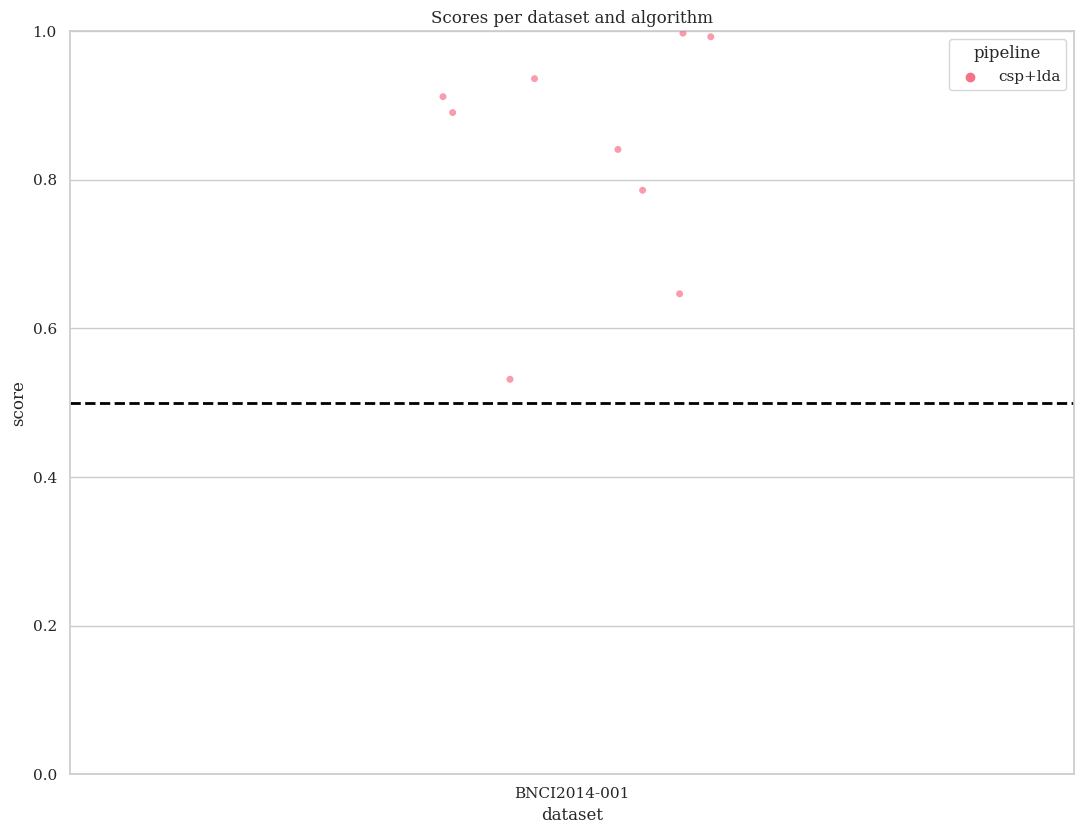

In [42]:
moabb.analysis.plotting.score_plot(results)

## **References**

* [1] MOABB - https://moabb.neurotechx.com/docs/api.html
* [2] Faker - https://faker-readthedocs-io.translate.goog/en/master/?_x_tr_sl=en&_x_tr_tl=pt&_x_tr_hl=pt&_x_tr_pto=tc